## Convolutional Neural Networks

Overview:
Implement Convolutional Neural Network that is especially good for reading and classifying images, to classify American Sign language image dataset. The model was able to learn how to correctly classify the training dataset and validation dataset with generalization to non-training data.

## Preparing the Data

In order to teach our model to be more robust when looking at new data, we're going to programmatically increase the size and variance in our dataset, also called data augmentation.

The increase in size gives the model more images to learn from while training. The increase in variance helps the model ignore unimportant features and select only the features that are truly important in classification, allowing it to generalize better.

In [15]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label'].values
y_valid = valid_df['label'].values
del train_df['label']
del valid_df['label']

# Separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24

y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

## Model Creation

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

## Data Augmentation

Before compiling the model, it's time to set up our data augmentation.

Keras comes with an image augmentation class called `ImageDataGenerator`. It accepts a series of options for augmenting your data. We would want to flip images horizontally, but not vertically. When you have an idea, reveal the text below.
Our dataset is pictures of hands signing the alphabet. If we want to use this model to classify hand images later, it's unlikely that those hands are going to be upside-down, but, they might be left-handed. This kind of domain-specific reasoning can help make good decisions for your own deep learning applications.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

## Batch Size
Another benefit of the `ImageDataGenerator` is that batch data helps our model to train on a random sample.

If the model is truly random, meaning that the data is properly shuffled so it's fair like a deck of cards, then our sample can do a good job of representing all of our data even though it is a tiny fraction of the population. For each step of the training, the model will be dealt a new batch.

In practice, a batch size of 32 and 64 does well. Run the cell below to see what kind of batches we'll be training our model with. Is our randomizer fairly randomizing? Are all of the images recognizable ASL letters?

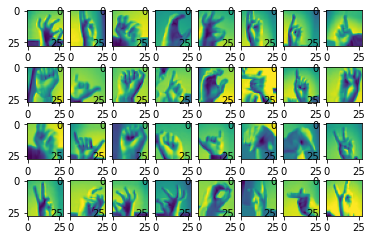

In [18]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## Fitting the Data to the Generator


Next, the generator must be fit on the training dataset.

In [19]:
datagen.fit(x_train)

## Compiling the Model

With the data generator instance created and fit to the training data, the model can now be compiled in the same way as our earlier examples:

In [21]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## Training with Augmentation

When using an image data generator with Keras, a model trains a bit differently: instead of just passing the `x_train` and `y_train` datasets into the model, we pass the generator in, calling the generator's flow method. This causes the images to get augmented live and in memory right before they are passed into the model for training.

Generators can supply an indefinite amount of data, and when we use them to train our data, we need to explicitly set how long we want each epoch to run, or else the epoch will go on indefinitely, with the generator creating an indefinite number of augmented images to provide the model.

We explicitly set how long we want each epoch to run using the `steps_per_epoch` named argument. Because `steps * batch_size = number_of_images_trained in an epoch` a common practice, that we will use here, is to set the number of steps equal to the non-augmented dataset size divided by the batch_size (which has a default value of 32).


In [22]:
model.fit(img_iter,
          epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/20
858/857 [==============================] - 52s 61ms/step - loss: 1.0556 - accuracy: 0.6582 - val_loss: 0.5042 - val_accuracy: 0.8486
Epoch 2/20
858/857 [==============================] - 36s 42ms/step - loss: 0.3110 - accuracy: 0.8960 - val_loss: 0.4838 - val_accuracy: 0.8367
Epoch 3/20
858/857 [==============================] - 36s 41ms/step - loss: 0.1921 - accuracy: 0.9364 - val_loss: 0.5382 - val_accuracy: 0.8427
Epoch 4/20
858/857 [==============================] - 38s 44ms/step - loss: 0.1490 - accuracy: 0.9505 - val_loss: 0.0597 - val_accuracy: 0.9762
Epoch 5/20
858/857 [==============================] - 38s 45ms/step - loss: 0.1183 - accuracy: 0.9619 - val_loss: 0.5977 - val_accuracy: 0.8516
Epoch 6/20
858/857 [==============================] - 38s 44ms/step - loss: 0.1132 - accuracy: 0.9653 - val_loss: 1.4568 - val_accuracy: 0.7836
Epoch 7/20
858/857 [==============================] - 38s 45ms/step - loss: 0.0958 - accuracy: 0.9700 - val_loss: 0.7998 - val_accuracy:

## Results

The validation accuracy is higher, and more consistent. This means that our model is not overfitted; it generalizes better, making better predictions on new data.
Augmenting the dataset helped in training the model with less overfitting and excellent validation image results.

## Making Predictions

In [32]:
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

## Scaling the images

The images in our dataset were 28x28 pixels and grayscale. We need to make sure to pass the same size and grayscale images into our method for prediction. There are a few ways to edit images with Python, but Keras has a built-in utility that works well. 

In [33]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_image(image_path):
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(28,28))
    return image

Each element of the prediction array represents a possible letter in the sign language alphabet. j and z are not options because they involve moving the hand, and we're only dealing with still photos. Let's create a mapping between the index of the predictions array, and the corresponding letter. 

In [39]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"
dictionary = {}
for i in range(24):
    dictionary[i] = alphabet[i]
dictionary

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'k',
 10: 'l',
 11: 'm',
 12: 'n',
 13: 'o',
 14: 'p',
 15: 'q',
 16: 'r',
 17: 's',
 18: 't',
 19: 'u',
 20: 'v',
 21: 'w',
 22: 'x',
 23: 'y'}

In [40]:
def predict_letter(file_path):
    # Show image
    show_image(file_path)
    # Load and scale image
    image = load_and_scale_image(file_path)
    # Convert to array
    image = image_utils.img_to_array(image)
    # Reshape image
    image = image.reshape(1,28,28,1)
    # Normalize image
    image = image/255
    # Make prediction
    prediction = model.predict(image)
    # Convert prediction to letter
    predicted_letter = dictionary[np.argmax(prediction)]
    # Return prediction
    return predicted_letter   

'b'

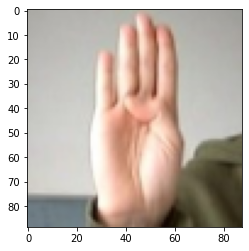

In [41]:
predict_letter("data/asl_images/b.png")

'a'

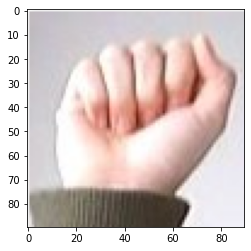

In [42]:
predict_letter("data/asl_images/a.png")

'k'

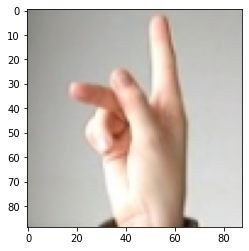

In [43]:
predict_letter("data/asl_images/k.png")

'y'

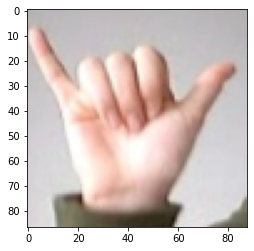

In [44]:
predict_letter("data/asl_images/y.png")